In [46]:
s1 = "Testing locality sensitive hashing using deep learning"
s2 = "Hashing variables with locality using reinforcement learning"

### Shingle Scoring using unigrams (Jaccard scores)

In [67]:
def shingleScoreSimple(s1, s2):
    s1 = s1.lower().split()
    s2 = s2.lower().split()
    return (len(list(set(s1).intersection(s2))))/(len(set(s1))+len(set(s2)))

In [33]:
shingleScoreSimple(s1,s2)

0.2857142857142857

### Shingle Scoring using k shingles

In [68]:
def splitShingle(s, k):
    shingles = []
    for i in range(len(s)-k):
        shingles.append(s[i:i+k])
    return shingles

def shingleScore(s1, s2, k):
    s1 = s1.lower()
    s2 = s2.lower()
    shingle1 = splitShingle(s1, k)
    shingle2 = splitShingle(s2, k)
    return (len(list(set(shingle1).intersection(shingle2))))/(len(set(shingle1))+len(set(shingle2)))

In [69]:
shingleScore(s1, s2, 3)

0.22549019607843138

## Data Testing

In [53]:
import numpy as np
import pandas as pd
import re
import time
from datasketch import MinHash, MinHashLSHForest
import matplotlib.pyplot as plt

In [111]:
df = pd.read_csv("/Users/siddharthjain/Downloads/papers.csv")
df.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [112]:
df.shape

(7241, 7)

In [51]:
df[df['abstract']=="Abstract Missing"].shape

(3317, 7)

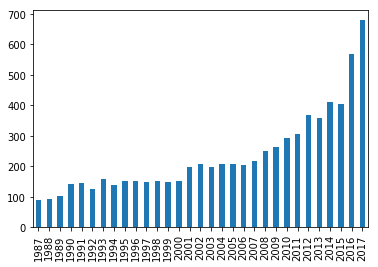

In [64]:
df.year.value_counts().sort_index().plot(kind='bar')

## Clean unigrams function

In [66]:
def preprocess(text):
    text = re.sub(r'[^\w\s]','',text)
    tokens = text.lower()
    tokens = tokens.split()
    return tokens

In [77]:
m = MinHash(num_perm=64)

In [74]:
tokens = preprocess(s1)
tokens

['testing', 'locality', 'sensitive', 'hashing', 'using', 'deep', 'learning']

## Functions for prediction

In [113]:
df['text'] = df['title'] + ' ' + df['paper_text']

In [114]:
def makeForest(data):
    minhash = []
    
    for paper in data['text']:
        m = MinHash(num_perm = 32)
        shingles = preprocess(paper)
        for gram in shingles:
            m.update(gram.encode('utf-8'))
        minhash.append(m)
    
    forest = MinHashLSHForest(num_perm = 32)
    
    for i, h in enumerate(minhash):
        forest.add(i, h)
        
    # Making keys query-able    
    forest.index()
    
    return forest

In [115]:
def predict(s, data, num_results, forest):
    shingles = preprocess(s)
    m = MinHash(num_perm= 32)
    for gram in shingles:
        m.update(gram.encode('utf-8'))
    
    indexes = np.array(forest.query(m, num_results))
    
    if len(indexes) == 0:
        return None
    
    result = data.iloc[indexes]['title']
    
    return result

In [137]:
forest = makeForest(df.head(2000))

In [139]:
sample = df.iloc[10]
s = sample['title']+' '+sample['text']
print(sample['title'])

Learning to Play the Game of Chess


In [142]:
%%time
res = predict(s, df, 5, forest)

CPU times: user 58.2 ms, sys: 1.7 ms, total: 59.9 ms
Wall time: 60.7 ms


In [141]:
for i in res:
    print(i)

Linking Motor Learning to Function Approximation: Learning in an Unlearnable Force Field
3D Object Recognition: A Model of View-Tuned Neurons
Learning to Play the Game of Chess
Geometrical Singularities in the Neuromanifold of Multilayer Perceptrons
Human and Ideal Observers for Detecting Image Curves
